In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
train = pd.read_csv('train.csv')

Drop outliers:

In [4]:
out_index = train[(train.GrLivArea > 4000) & (train.SalePrice < 200000)].index

In [5]:
train.drop(out_index, axis=0, inplace=True)

In [6]:
#train = train[train['GrLivArea'] <= 4000]
train.loc[train['LotArea'] > 30000, 'LotArea'] = 30000

Fill missing values according to logic that NaN represent abscence of the particular feature in the house

In [7]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].fillna('N_A', inplace=True)
    else:
        train[col].fillna(0, inplace=True)

In [8]:
mapping = {'N_A': 0, 
           'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

In [9]:
for col in train.columns:
    if train[col].unique().any() in ['TA', 'Gd', 'Fa', 'Po', 'Ex']:
        train[col] = train[col].map(mapping)

In [10]:
train['FireplaceQu'] = train['FireplaceQu'].map(mapping)

Generated feature - years scince renovation:

In [11]:
train['yr_since_renovation'] = (train['YrSold'] - train['YearRemodAdd'])

Keep only residential properties

Cathegories transformation:

In [12]:
train['AreaQual'] = train['GrLivArea'] * train['OverallQual'] * train['OverallCond']
train['FireplaceQual'] = train['Fireplaces'] * train['FireplaceQu']
train['Bath'] = train['FullBath'] + 0.5 * train['HalfBath']
train['BsmtQuCondSF'] = train['TotalBsmtSF'] * train['BsmtCond'] * train['BsmtQual']
train['DeckPorchSF'] = train[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)
train['TotalLivingSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['BsmtBath'] = train['BsmtFullBath'] + 0.5 * train['BsmtHalfBath']
train['ExterQC'] = train['ExterQual'] + train['ExterCond']
train['KitchenQC'] = train['KitchenAbvGr'] * train['KitchenQual']
train['HouseAge'] = train['YrSold'] - train['YearBuilt']

In [13]:
train['Finished'] = train['yr_since_renovation'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
train['GarageQu'] = train['GarageQual'] * train['GarageArea'] * train['GarageCond']

Drop unnecessaries

In [15]:
train.drop(['MSSubClass', 'MSZoning'], axis=1, inplace=True)

In [16]:
train.drop('Id', axis=1, inplace=True)

In [17]:
train.drop('LotFrontage', axis=1, inplace=True)

In [18]:
#train['AreaQual'] = np.log(train['AreaQual'])
#train['SalePrice'] = np.log(train['SalePrice'])

Transformation into ordinal feature:

In [19]:
neighborhoods = (train.groupby('Neighborhood')['SalePrice']
                 .agg(['mean', 'median', 'count'])
                 .sort_values(by='median', ascending=False))

In [20]:
n_sorted = neighborhoods.sort_values(by='median').index

In [21]:
for i, n in enumerate(n_sorted):
    train.loc[train['Neighborhood'] == n, 'neighborhoods_ordinal'] = int(i+1)

In [22]:
train.drop('Neighborhood', axis=1, inplace=True)

In [23]:
skewness = train.skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

/var/folders/5j/zxljzwc916b6zz6z50f_wy740000gn/T/ipykernel_6960/3372031453.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = train.skew().sort_values(ascending=False)


MiscVal          24.460085
PoolArea         15.948945
3SsnPorch        10.297106
LowQualFinSF      9.004955
KitchenAbvGr      4.484883
BsmtFinSF2        4.251925
ScreenPorch       4.118929
BsmtHalfBath      4.100114
EnclosedPorch     3.087164
MasVnrArea        2.696329
OpenPorchSF       2.339829
AreaQual          2.240765
SalePrice         1.881296
LotArea           1.638061
WoodDeckSF        1.545805
ExterCond         1.395464
KitchenQC         1.286082
BsmtQuCondSF      1.174327
DeckPorchSF       1.104405
GrLivArea         1.010992
TotalLivingSF     0.957325
BsmtUnfSF         0.920903
1stFlrSF          0.887637
FireplaceQual     0.861493
ExterQual         0.820047
2ndFlrSF          0.812957
BsmtFinSF1        0.764789
BsmtQual         -1.294561
Finished         -2.994033
GarageQual       -3.225777
GarageCond       -3.329037
BsmtCond         -3.698126
GarageYrBlt      -3.866380
dtype: float64

In [24]:
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [
    col for col in skewed_cols if col not in ['SalePrice']
]

# Log-transform skewed columns
for col in skewed_cols:
    train[col] = np.log(1 + train[col])

In [25]:
#train['AreaQual'] = np.log(train['AreaQual'])
#train['DeckPorchSF'] = np.log(train['DeckPorchSF'])
#train['TotalLivingSF'] = np.log(train['TotalLivingSF'])
#train['SalePrice'] = np.log(train['SalePrice'])

/var/folders/5j/zxljzwc916b6zz6z50f_wy740000gn/T/ipykernel_6960/1631727080.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train.hist(ax = ax, bins=30)


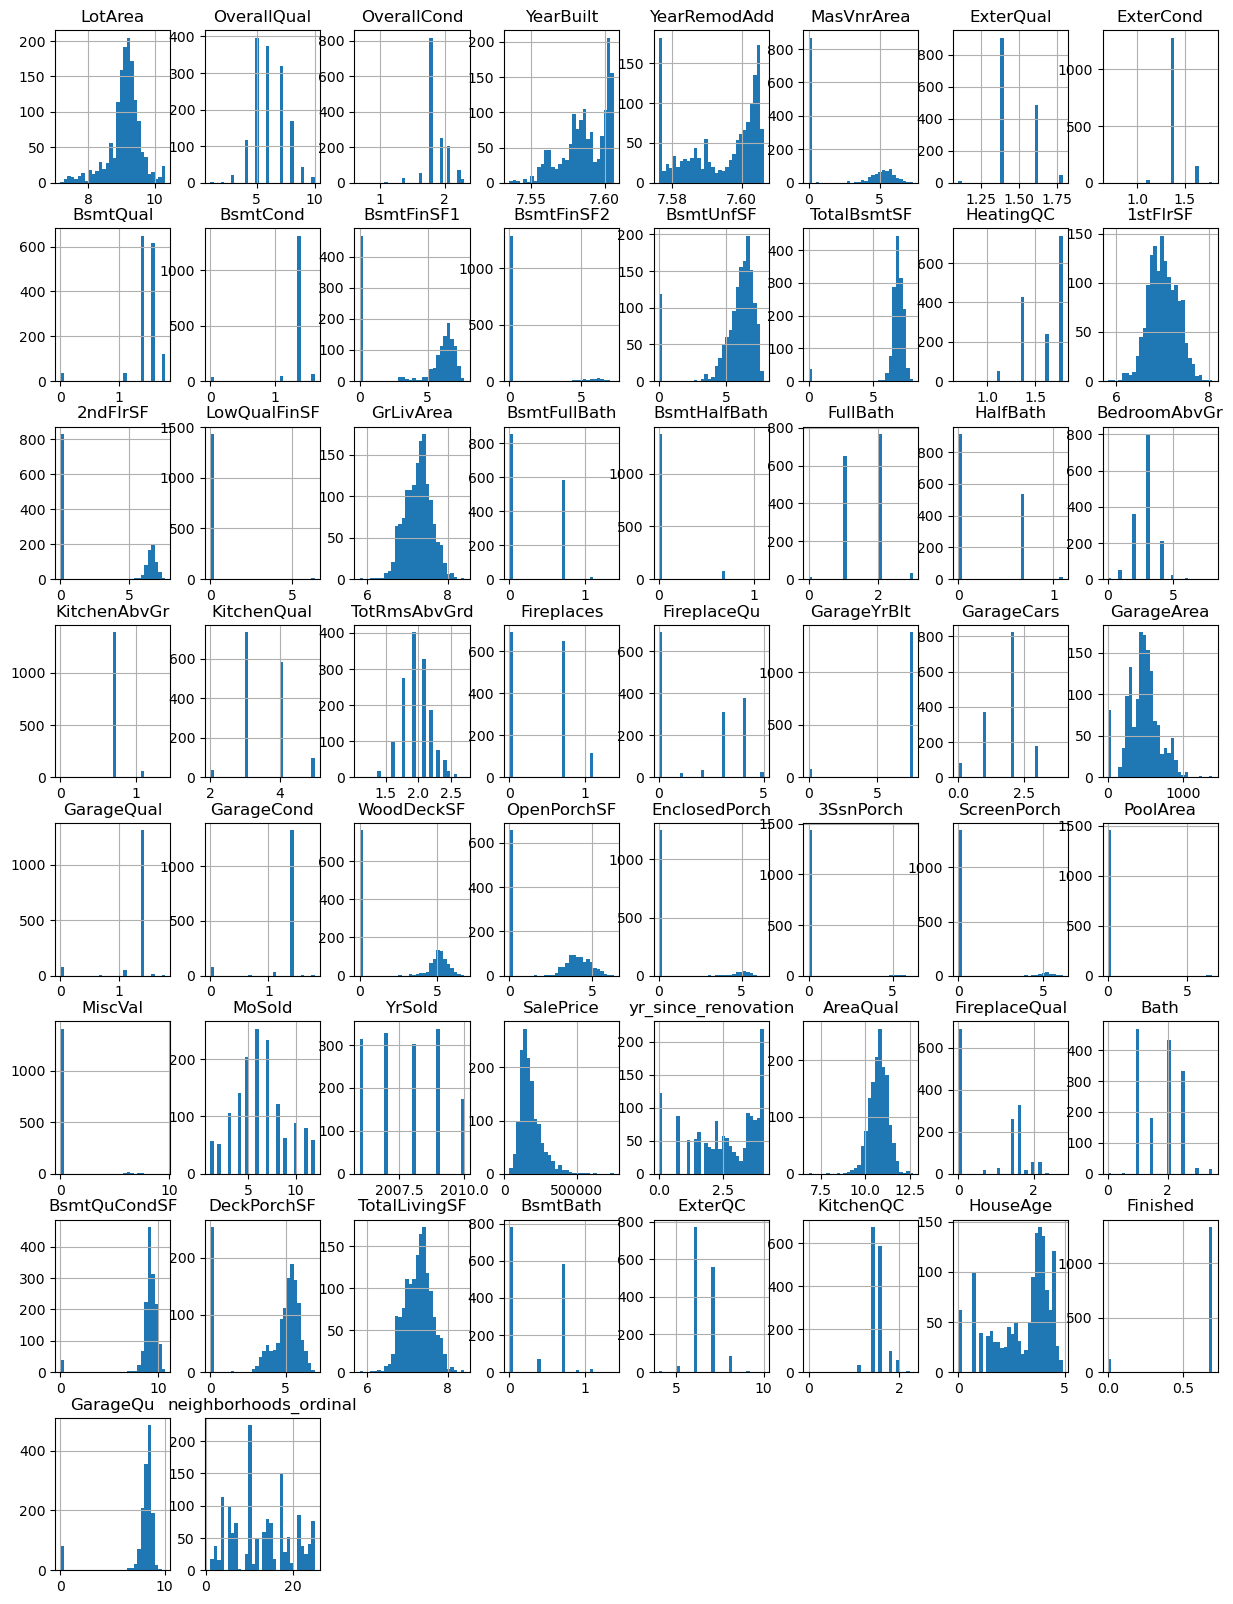

In [26]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=30)
plt.show()

In [27]:
train.head()

,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,yr_since_renovation,AreaQual,FireplaceQual,Bath,BsmtQuCondSF,DeckPorchSF,TotalLivingSF,BsmtBath,ExterQC,KitchenQC,HouseAge,Finished,GarageQu,neighborhoods_ordinal
0,9.042040,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,7,1.791759,7.602900,7.602900,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,1.609438,1.386294,PConc,1.609438,1.386294,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,1.791759,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,4,2.197225,Typ,0.000000,0,Attchd,7.602900,RFn,2,548,1.386294,1.386294,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,N_A,N_A,N_A,0.0,2,2008,WD,Normal,208500,1.791759,10.999613,0.000000,2.5,9.237274,4.127134,7.444833,0.693147,7,1.609438,1.791759,0.693147,8.503703,17.0
1,9.169623,Pave,N_A,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,1Fam,1Story,6,2.197225,7.589336,7.589336,Gable,CompShg,MetalSd,MetalSd,None,0.000000,1.386294,1.386294,CBlock,1.609438,1.386294,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,1.791759,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,3,1.945910,Typ,0.693147,3,Attchd,7.589336,RFn,2,460,1.386294,1.386294,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,N_A,N_A,N_A,0.0,5,2007,WD,Normal,181500,3.465736,11.011671,1.386294,2.0,9.625426,5.700444,7.141245,0.405465,6,1.386294,3.465736,0.693147,8.328693,20.0
2,9.328212,Pave,N_A,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,7,1.791759,7.601902,7.602401,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,1.609438,1.386294,PConc,1.609438,1.386294,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,1.791759,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,4,1.945910,Typ,0.693147,3,Attchd,7.601902,RFn,2,608,1.386294,1.386294,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,N_A,N_A,N_A,0.0,9,2008,WD,Normal,223500,1.945910,11.043098,1.386294,2.5,9.309371,3.761200,7.488294,0.693147,7,1.609438,2.079442,0.693147,8.607582,17.0
3,9.164401,Pave,N_A,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,2Story,7,1.791759,7.557995,7.586296,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,1.386294,1.386294,BrkTil,1.386294,1.609438,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,1.609438,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,4,2.079442,Typ,0.693147,4,Detchd,7.600402,Unf,3,642,1.386294,1.386294,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,N_A,N_A,N_A,0.0,2,2006,WD,Abnorml,140000,3.610918,11.003699,1.609438,1.0,9.113058,5.730100,7.448916,0.693147,6,1.609438,4.521789,0.693147,8.661986,19.0
4,9.565284,Pave,N_A,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,1Fam,2Story,8,1.791759,7.601402,7.601402,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,1.609438,1.386294,PConc,1.609438,1.386294,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,1.791759,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,4,2.302585,Typ,0.693147,3,Attchd,7.601402,RFn,3,836,1.386294,1.386294,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,N_A,N_A,N_A,0.0,12,2008,WD,Normal,250000,2.197225,11.384194,1.386294,2.5,9.528139,5.624018,7.695758,0.693147,7,1.609438,2.197225,0.693147,8.925986,24.0


In [28]:
train.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,yr_since_renovation,AreaQual,FireplaceQual,Bath,BsmtQuCondSF,DeckPorchSF,TotalLivingSF,BsmtBath,ExterQC,KitchenQC,HouseAge,Finished,GarageQu,neighborhoods_ordinal
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,9.100068,6.093964,1.869372,7.586796,7.593740,2.114038,1.472124,1.403473,1.471885,1.351232,4.224311,0.656297,5.647261,6.748318,1.618549,7.006746,2.858779,0.099951,7.266762,0.290565,0.039540,1.563786,0.262435,2.866255,0.711699,3.509602,1.993679,0.398997,1.822359,7.168809,1.766118,472.050069,1.301358,1.300978,2.453229,2.303690,0.698976,0.085796,0.411235,0.026237,0.233776,6.323045,2007.816187,180932.919067,2.576752,10.744729,0.826451,1.754801,9.041563,4.246671,7.262974,0.312638,6.477366,1.520684,3.054231,0.634672,7.855410,12.849108
std,0.483175,1.376369,0.168491,0.015385,0.010422,2.625175,0.125470,0.083384,0.279300,0.230240,2.990471,1.846151,1.855010,1.144830,0.201881,0.314193,3.291819,0.747857,0.330142,0.349280,0.162704,0.549891,0.341731,0.816323,0.089326,0.661919,0.213483,0.394008,1.810325,1.739331,0.747104,212.239248,0.322729,0.323089,2.595991,2.149862,1.728308,0.667326,1.404074,0.408374,1.226840,2.700167,1.328826,79495.055285,1.286766,0.542929,0.812174,0.634509,1.540606,2.075330,0.330435,0.345777,0.673935,0.176319,1.312660,0.192713,1.956664,6.685031
min,7.170888,1.000000,0.693147,7.535297,7.576097,0.000000,1.098612,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,5.814131,0.000000,0.000000,5.814131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,6.807935,0.000000,0.000000,0.000000,0.000000,5.814131,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.928706,5.000000,1.791759,7.578145,7.584773,0.000000,1.386294,1.386294,1.386294,1.386294,0.000000,0.000000,5.411646,6.679913,1.386294,6.783325,0.000000,0.000000,7.029530,0.000000,0.000000,1.000000,0.000000,2.000000,0.693147,3.000000,1.791759,0.000000,0.000000,7.580189,1.000000,331.500000,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129925.000000,1.609438,10.414693,0.000000,1.000000,8.955738,3.828641,7.024871,0.000000,6.000000,1.386294,2.197225,0.693147,7.940584,7.000000
50%,9.156518,6.000000,1.791759,7.587564,7.598399,0.000000,1.386294,1.386294,1.609438,1.386294,5.948032,0.000000,6.170651,6.899723,1.791759,6.991177,0.000000,0.000000,7.287901,0.000000,0.000000,2.000000,0.000000,3.000000,0.693147,3.000000,1.945910,0.693147,2.000000,7.589842,2.000000,479.500000,1.386294,1.386294,0.000000,3.238486,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,2.708050,10.783134,1.098612,2.000000,9.225672,5.105945,7.284821,0.000000,6.000000,1.609438,3.583519,0.693147,8

### Modeling

In [29]:
from catboost import Pool, CatBoostRegressor

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [31]:
def extract_cat_features(data):
    cat_features = []
    num_features = []
    for i, col in enumerate(data.columns):
        if data[col].dtype == 'object':
            cat_features.append(col)
        elif data[col].dtype == 'bool':
            cat_features.append(col)
        else:
            num_features.append(col)
    #cat_features.append('MSSubClass') #!! is numeric but represents categories
    return cat_features, num_features

In [32]:
def prepare_and_split_data(input_data, test_size=0):
    data = input_data.copy()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col].fillna('N_A', inplace=True)
        else:
            data[col].fillna(0, inplace=True)
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [33]:
cat_features, num_features = extract_cat_features(train)

In [96]:
X_train, X_test, y_train, y_test = prepare_and_split_data(train, test_size=.05)

In [119]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

#test_pool = Pool(test, 
#                 cat_features=cat_features) 

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=600, 
                          depth=5, 
                          learning_rate=0.1, 
                          loss_function='MAE',
                          l2_leaf_reg=8,
                          one_hot_max_size=30,
                          random_state=42,
                          random_strength=1,
                          
                          #ignored_features=ignored_features,
                          
                          verbose=100
                          )
#train the model
model.fit(train_pool)#, eval_set=eval_pool)#, early_stopping_rounds=20)
# make the prediction using the resulting model
preds = model.predict(eval_pool)
np.sqrt(mean_squared_error(preds, y_test))

0:	learn: 51946.4006651	total: 3.05ms	remaining: 1.83s
100:	learn: 10908.7575828	total: 138ms	remaining: 683ms
200:	learn: 8396.5740407	total: 265ms	remaining: 526ms
300:	learn: 7213.0915655	total: 392ms	remaining: 390ms
400:	learn: 6492.3189427	total: 517ms	remaining: 257ms
500:	learn: 5977.6139292	total: 643ms	remaining: 127ms
599:	learn: 5624.6499051	total: 767ms	remaining: 0us


16539.741529362498

In [120]:
np.sqrt(mean_squared_error(preds, y_test))

16539.741529362498

In [113]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [114]:
np.sqrt(mean_squared_log_error(preds, y_test))

0.09582376563877108

In [110]:
r2_score(preds, y_test)

0.9408444053549303

In [40]:
pd.Series((preds - y_test).sort_values(ascending=True))

1182   -157292.645150
218     -68013.544914
426     -61031.203324
451     -38366.922318
231     -38254.509303
            ...      
477      45124.209005
1322     45815.040757
716      54480.300137
70       56534.832127
529      68774.057999
Name: SalePrice, Length: 365, dtype: float64

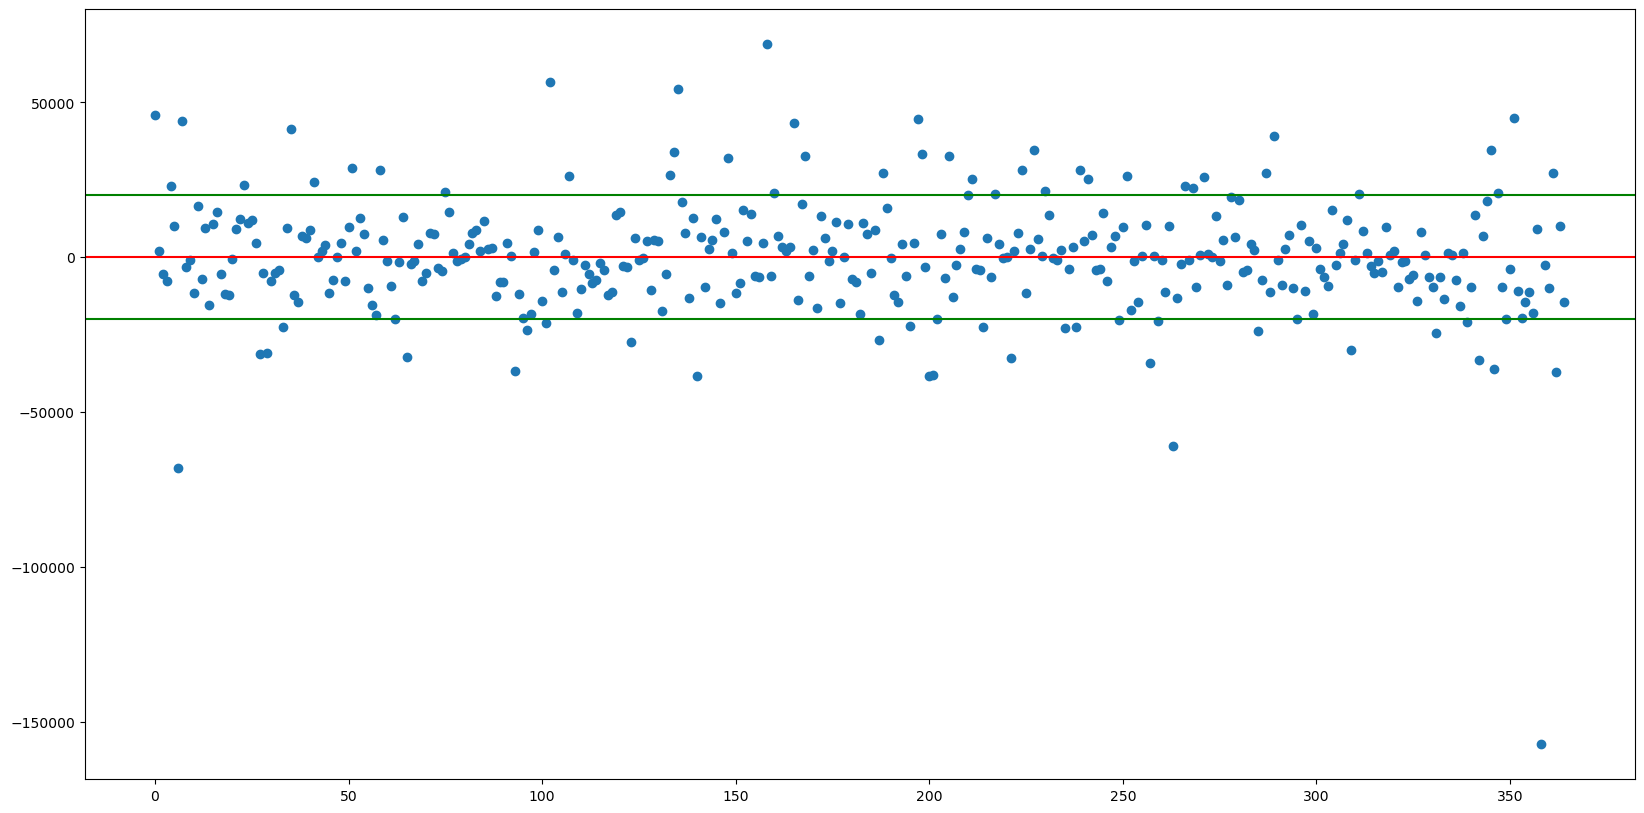

In [41]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(preds)), (preds - y_test))
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

In [42]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,AreaQual,12.816932
1,neighborhoods_ordinal,8.247640
2,TotalLivingSF,6.040752
3,LotArea,5.272880
4,BsmtQuCondSF,4.387120
5,TotalBsmtSF,4.227474
6,OverallQual,3.889731
7,1stFlrSF,3.533523
8,HouseAge,3.251758
9,DeckPorchSF,2.851781


In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [44]:
def data_preprocessing(data_train, test_size=.25):
    X_train, X_test, y_train, y_test = train_test_split(data_train.drop('SalePrice', axis=1), 
                                                        data_train['SalePrice'], 
                                                        test_size=test_size, 
                                                        random_state=42)
    categories = []
    for col in data_train.columns:
        if data_train[col].dtype == 'object':
            categories.append(col)
    ohe = OneHotEncoder(handle_unknown='infrequent_if_exist')
    ohe.fit(X_train[categories])
    cat_features_df = pd.DataFrame(ohe.transform(X_train[categories]).toarray(), 
                                   index=X_train.index, 
                                   columns=ohe.get_feature_names_out())
    X_train.drop(categories, axis=1, inplace=True)
    X = X_train.join(cat_features_df)
    test_cat_features_df = pd.DataFrame(ohe.transform(X_test[categories]).toarray(), 
                                        index=X_test.index, 
                                        columns=ohe.get_feature_names_out())
    X_test.drop(categories, axis=1, inplace=True)
    X_t = X_test.join(test_cat_features_df)
    return X, X_t, y_train, y_test

In [45]:
X_train1, X_test1, y_train1, y_test1 = data_preprocessing(train[num_features], test_size=.25)

In [46]:
from sklearn.preprocessing import RobustScaler

In [47]:
#scaler = RobustScaler()
scaler = StandardScaler()

In [48]:
scaler.fit(X_train1)

StandardScaler()

In [49]:
X_train1_s = scaler.transform(X_train1)
X_test1_s = scaler.transform(X_test1)

In [50]:
y_train_log = np.log(y_train1)
y_test_log = np.log(y_test1)

In [51]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [52]:
lasso = Lasso(alpha=50.0, 
      fit_intercept=True, 
      precompute=False, 
      copy_X=True, 
      max_iter=5000, 
      tol=0.0001, 
      warm_start=False, 
      positive=False, 
      random_state=42, 
      selection='random')

In [53]:
lasso.fit(X_train1_s, y_train1)

/Users/gdyskin/opt/anaconda3/envs/YDATA/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+09, tolerance: 6.971e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=50.0, max_iter=5000, random_state=42, selection='random')

In [54]:
lasso_preds = lasso.predict(X_test1_s)

In [55]:
np.sqrt(mean_squared_error(lasso.predict(X_test1_s), y_test1))

29435.685412282655

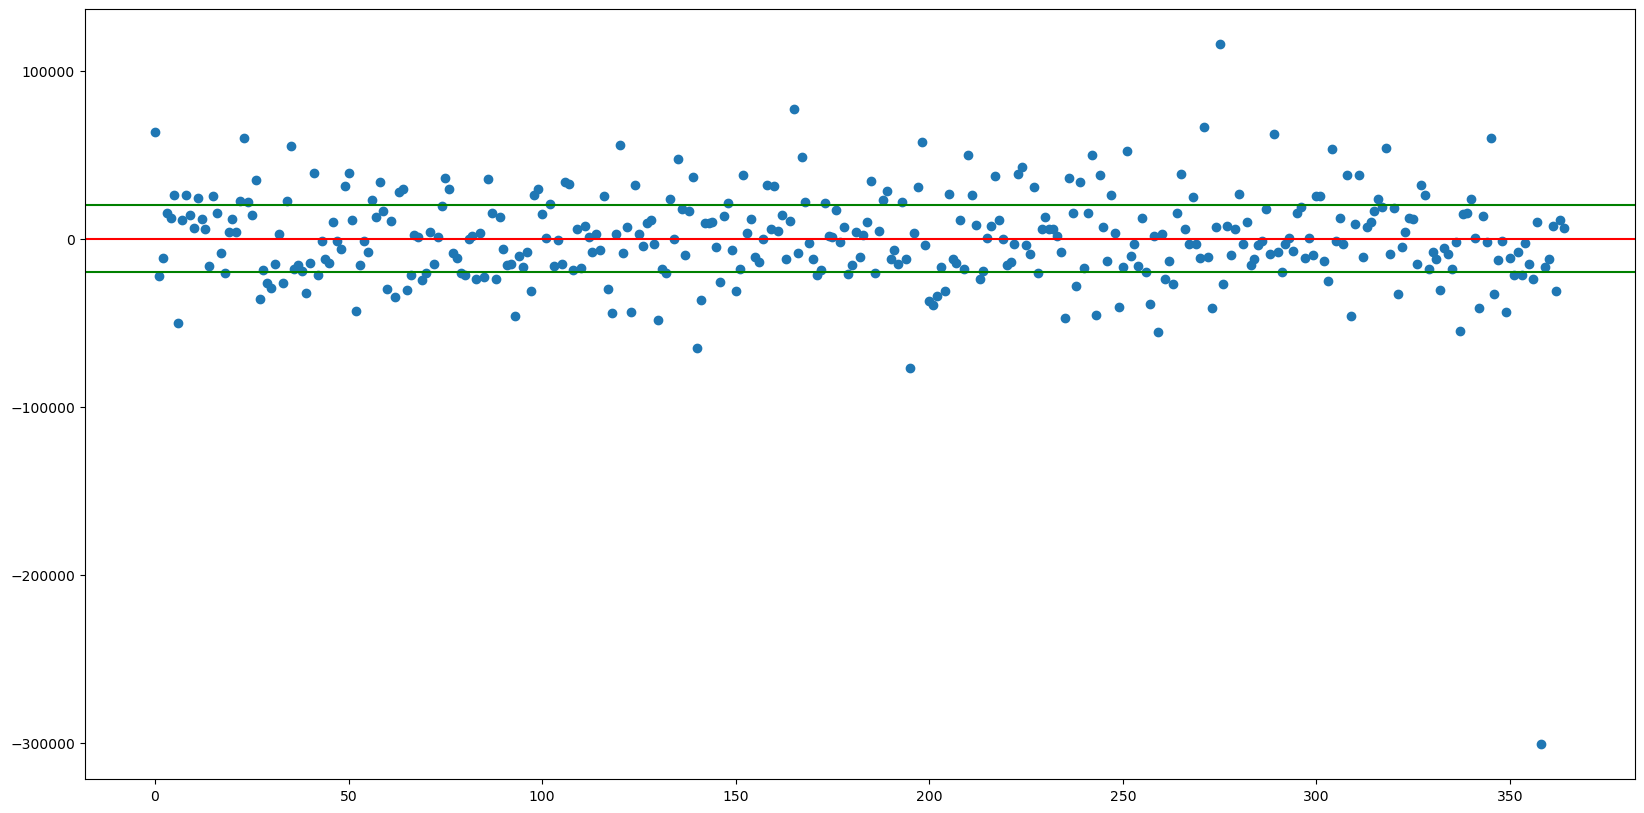

In [56]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), lasso.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

### SVR

In [57]:
from sklearn.svm import SVR

In [58]:
svr = SVR(kernel='linear', 
          degree=1, 
          gamma='scale', 
          coef0=0.0, 
          tol=0.001, 
          C=300.0, 
          epsilon=0.1, 
          shrinking=True, 
          cache_size=200, 
          verbose=False, 
          max_iter=10000)

In [59]:
svr.fit(X_train1_s, y_train1)

/Users/gdyskin/opt/anaconda3/envs/YDATA/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(C=300.0, degree=1, kernel='linear', max_iter=10000)

In [60]:
svr_preds = svr.predict(X_test1_s)

In [61]:
np.sqrt(mean_squared_error(svr.predict(X_test1_s), y_test1))

33958.65137812534

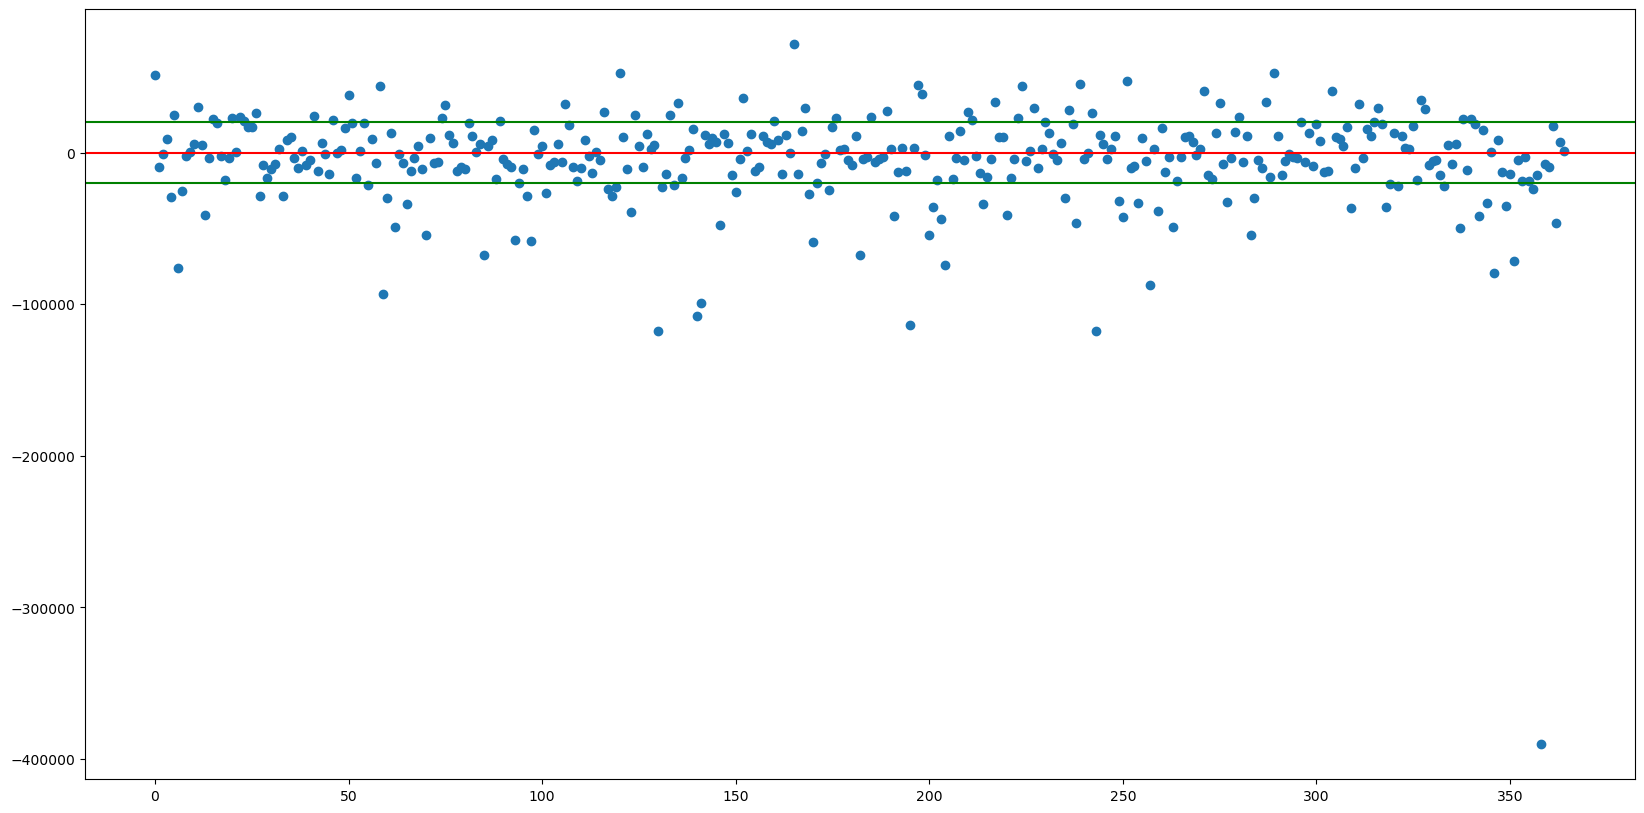

In [62]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), svr.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

In [63]:
ridge = Ridge(alpha=1.0, 
      fit_intercept=True, 
      copy_X=True, 
      max_iter=None, 
      tol=0.0001, 
      solver='auto', 
      positive=False, 
      random_state=42)

In [64]:
ridge.fit(X_train1_s, y_train1)

Ridge(random_state=42)

In [65]:
ridge_preds = ridge.predict(X_test1_s)

In [66]:
np.sqrt(mean_squared_error(ridge.predict(X_test1_s), y_test1))

29569.959131196803

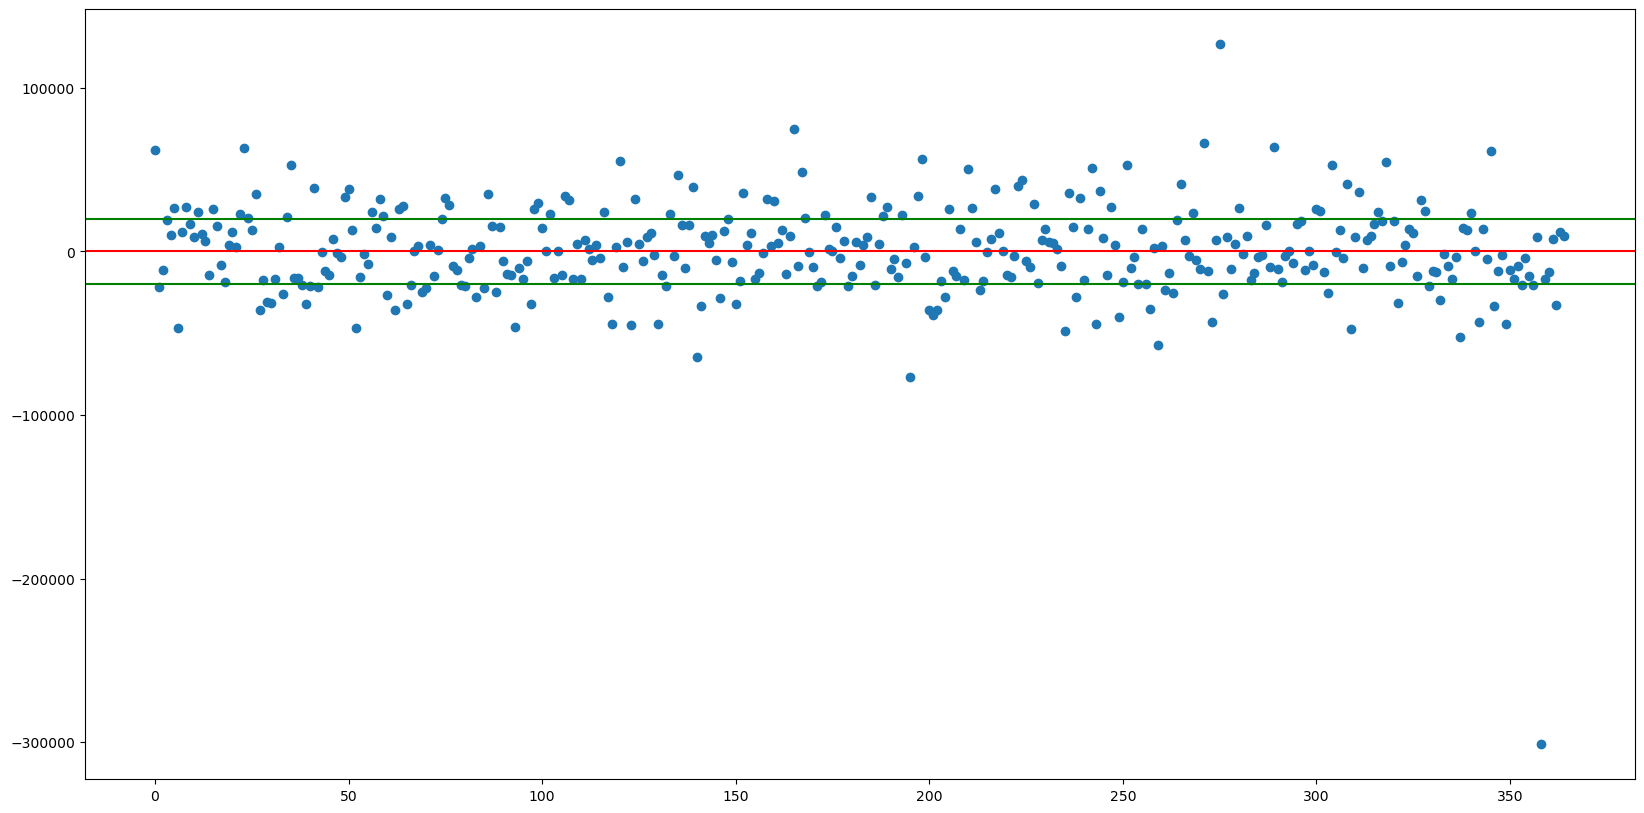

In [67]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), ridge.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

In [68]:
import xgboost 





In [69]:
model_xgb = xgboost.XGBRegressor(max_depth=3, 
                                 booster="gbtree", 
                                 learning_rate=0.1, 
                                 subsample=0.3, 
                                 reg_lambda=5, 
                                 n_estimators=100)
model_xgb.fit(X_train1_s, y_train1)
test_predictions = model_xgb.predict(X_test1_s)

np.sqrt(mean_squared_error(y_test1, test_predictions))

23307.358103496957

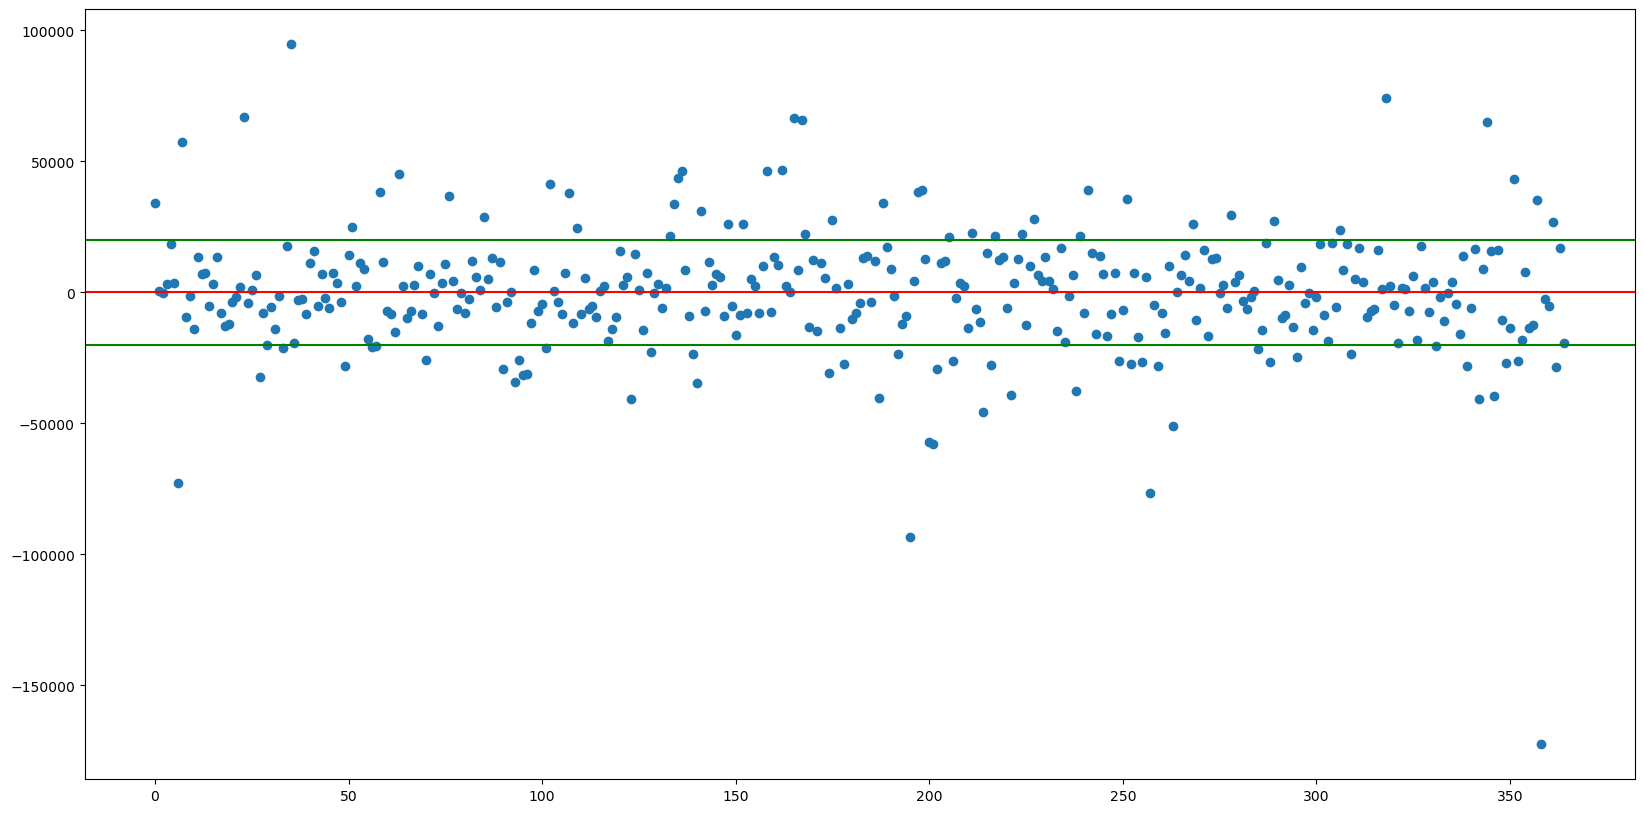

In [70]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), model_xgb.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

### CatBoost processed features

In [71]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

#test_pool = Pool(test, 
#                 cat_features=cat_features) 

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=900, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='MAE',
                          l2_leaf_reg=6,
                          one_hot_max_size=30,
                          #od_type = "Iter",
                          #od_wait = 100,
                          random_state=42,
                          random_strength=1,
                          
                          #ignored_features=ignored_features,
                          
                          verbose=100
                          )
#train the model
model.fit(X_train1_s, y_train1)#, eval_set=eval_pool, early_stopping_rounds=20)
# make the prediction using the resulting model
preds = model.predict(X_test1_s)
np.sqrt(mean_squared_error(preds, y_test1))

0:	learn: 51855.2625288	total: 1.3ms	remaining: 1.17s
100:	learn: 13285.5415820	total: 79ms	remaining: 625ms
200:	learn: 11389.3999528	total: 143ms	remaining: 497ms
300:	learn: 10405.8495192	total: 205ms	remaining: 407ms
400:	learn: 9775.6636255	total: 264ms	remaining: 329ms
500:	learn: 9266.5751523	total: 326ms	remaining: 260ms
600:	learn: 8907.3667959	total: 385ms	remaining: 192ms
700:	learn: 8602.4227583	total: 445ms	remaining: 126ms
800:	learn: 8347.2860300	total: 506ms	remaining: 62.6ms
899:	learn: 8101.5208783	total: 566ms	remaining: 0us


20278.260443005132

In [72]:
np.sqrt(mean_squared_log_error(preds, y_test))

0.11941153139758208

In [73]:
r2_score(preds, y_test)

0.9253281230511682

In [74]:
pd.Series((preds - y_test).sort_values(ascending=True))

1182   -136825.496526
608     -79306.423137
218     -76581.510301
426     -55049.985041
322     -54499.835079
            ...      
825      53660.986232
30       54003.757970
666      55585.731200
1173     55749.344005
70       57365.319525
Name: SalePrice, Length: 365, dtype: float64

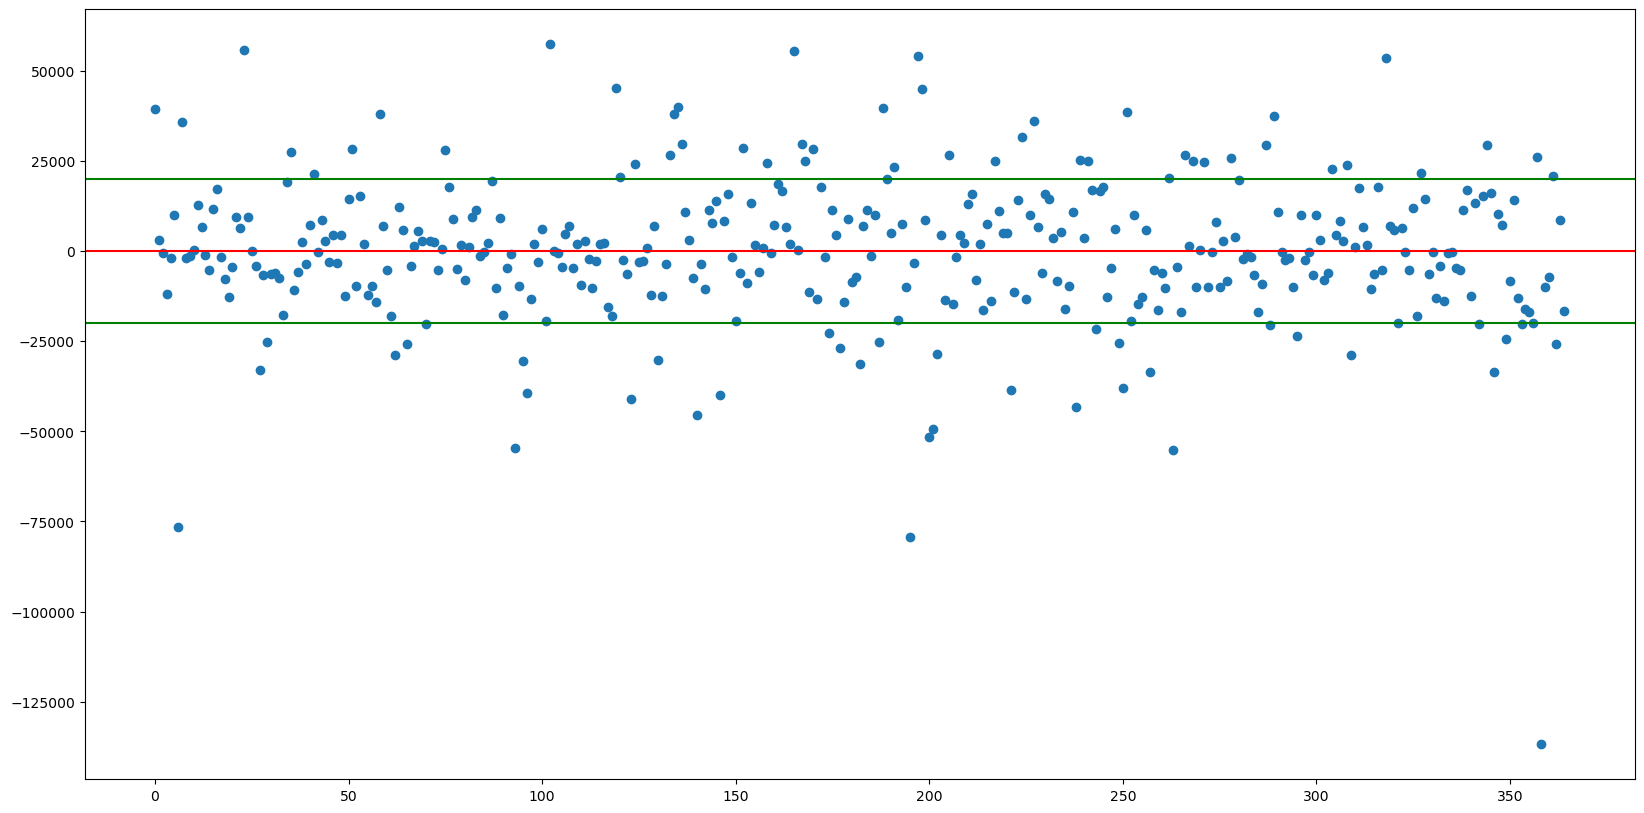

In [75]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(preds)), (preds - y_test))
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

### Submission

In [121]:
X, y = prepare_and_split_data(train)

In [122]:
sub_train_pool = Pool(X, y, 
                 cat_features=cat_features)

In [123]:
model.fit(sub_train_pool)

0:	learn: 51814.9607116	total: 3.74ms	remaining: 2.24s
100:	learn: 11140.1915367	total: 147ms	remaining: 724ms
200:	learn: 8632.0361269	total: 278ms	remaining: 552ms
300:	learn: 7350.8616170	total: 408ms	remaining: 405ms
400:	learn: 6564.7767657	total: 535ms	remaining: 266ms
500:	learn: 6023.2187467	total: 660ms	remaining: 130ms
599:	learn: 5573.6097631	total: 788ms	remaining: 0us


In [124]:
test = pd.read_csv('test_preprocessed.csv')

In [125]:
preds = model.predict(test)

In [126]:
preds

array([131622.0703173 , 167729.88615071, 197458.63573431, ...,
       158875.03871057, 120157.43806988, 210300.96934268])

In [82]:
test_id = pd.read_csv('test.csv')

In [83]:
sub_test = test_id.copy()

In [84]:
sub_test['SalePrice'] = pd.Series(preds)

### Output

In [85]:
#sub_test[['Id', 'SalePrice']].to_csv('out.csv', index=False)

In [86]:
#np.sqrt(mean_squared_error(model.predict(X), y))